In [4]:
import tensorflow as tf
from tensorflow import keras

print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


## Densenet

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Function to create a DataFrame for the dataset
def create_df(data_path):
    classes, class_paths = zip(*[(label, os.path.join(data_path, label, image))
                                 for label in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, label))
                                 for image in os.listdir(os.path.join(data_path, label))])
    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

# Load data
train_df = create_df('cleaned/Training')
test_df = create_df('cleaned/Testing')

# Split data into validation and test sets
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using data generators
batch_size = 32
img_size = (224, 224)

tr_gen = train_datagen.flow_from_dataframe(train_df, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size, class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size, class_mode='categorical')
ts_gen = test_datagen.flow_from_dataframe(test_df, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load the DenseNet121 base model with pre-trained ImageNet weights, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')

# Fine-tuning the DenseNet model: freezing initial layers and leaving last few layers trainable
for layer in base_model.layers[:300]:
    layer.trainable = False
for layer in base_model.layers[300:]:
    layer.trainable = True

# Define the custom model by adding layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Callbacks for early stopping, model checkpointing, and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Train the model with the data generators and callbacks
hist = model.fit(
    tr_gen,
    validation_data=valid_gen,
    epochs=10,
    verbose=1,
    callbacks=callbacks,
    shuffle=False
)


Found 4945 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Epoch 1/10
155/155 [==============================] - 82s 401ms/step - loss: 1.9954 - accuracy: 0.3181 - precision: 0.3301 - recall: 0.2499 - val_loss: 0.8486 - val_accuracy: 0.7088 - val_precision: 0.8684 - val_recall: 0.4231
Epoch 2/10
155/155 [==============================] - 55s 353ms/step - loss: 1.4065 - accuracy: 0.4532 - precision: 0.4885 - recall: 0.3743 - val_loss: 0.6125 - val_accuracy: 0.8004 - val_precision: 0.8903 - val_recall: 0.6538
Epoch 3/10
155/155 [==============================] - 56s 363ms/step - loss: 1.1552 - accuracy: 0.5525 - precision: 0.6038 - recall: 0.4811 - val_loss: 0.4983 - val_accuracy: 0.8388 - val_precision: 0.8710 - val_recall: 0.7546
Epoch 4/10
155/155 [==============================] - 54s 348ms/step - loss: 0.9758 - accuracy: 0.6241 - precision: 0.6706 - recall: 0.557

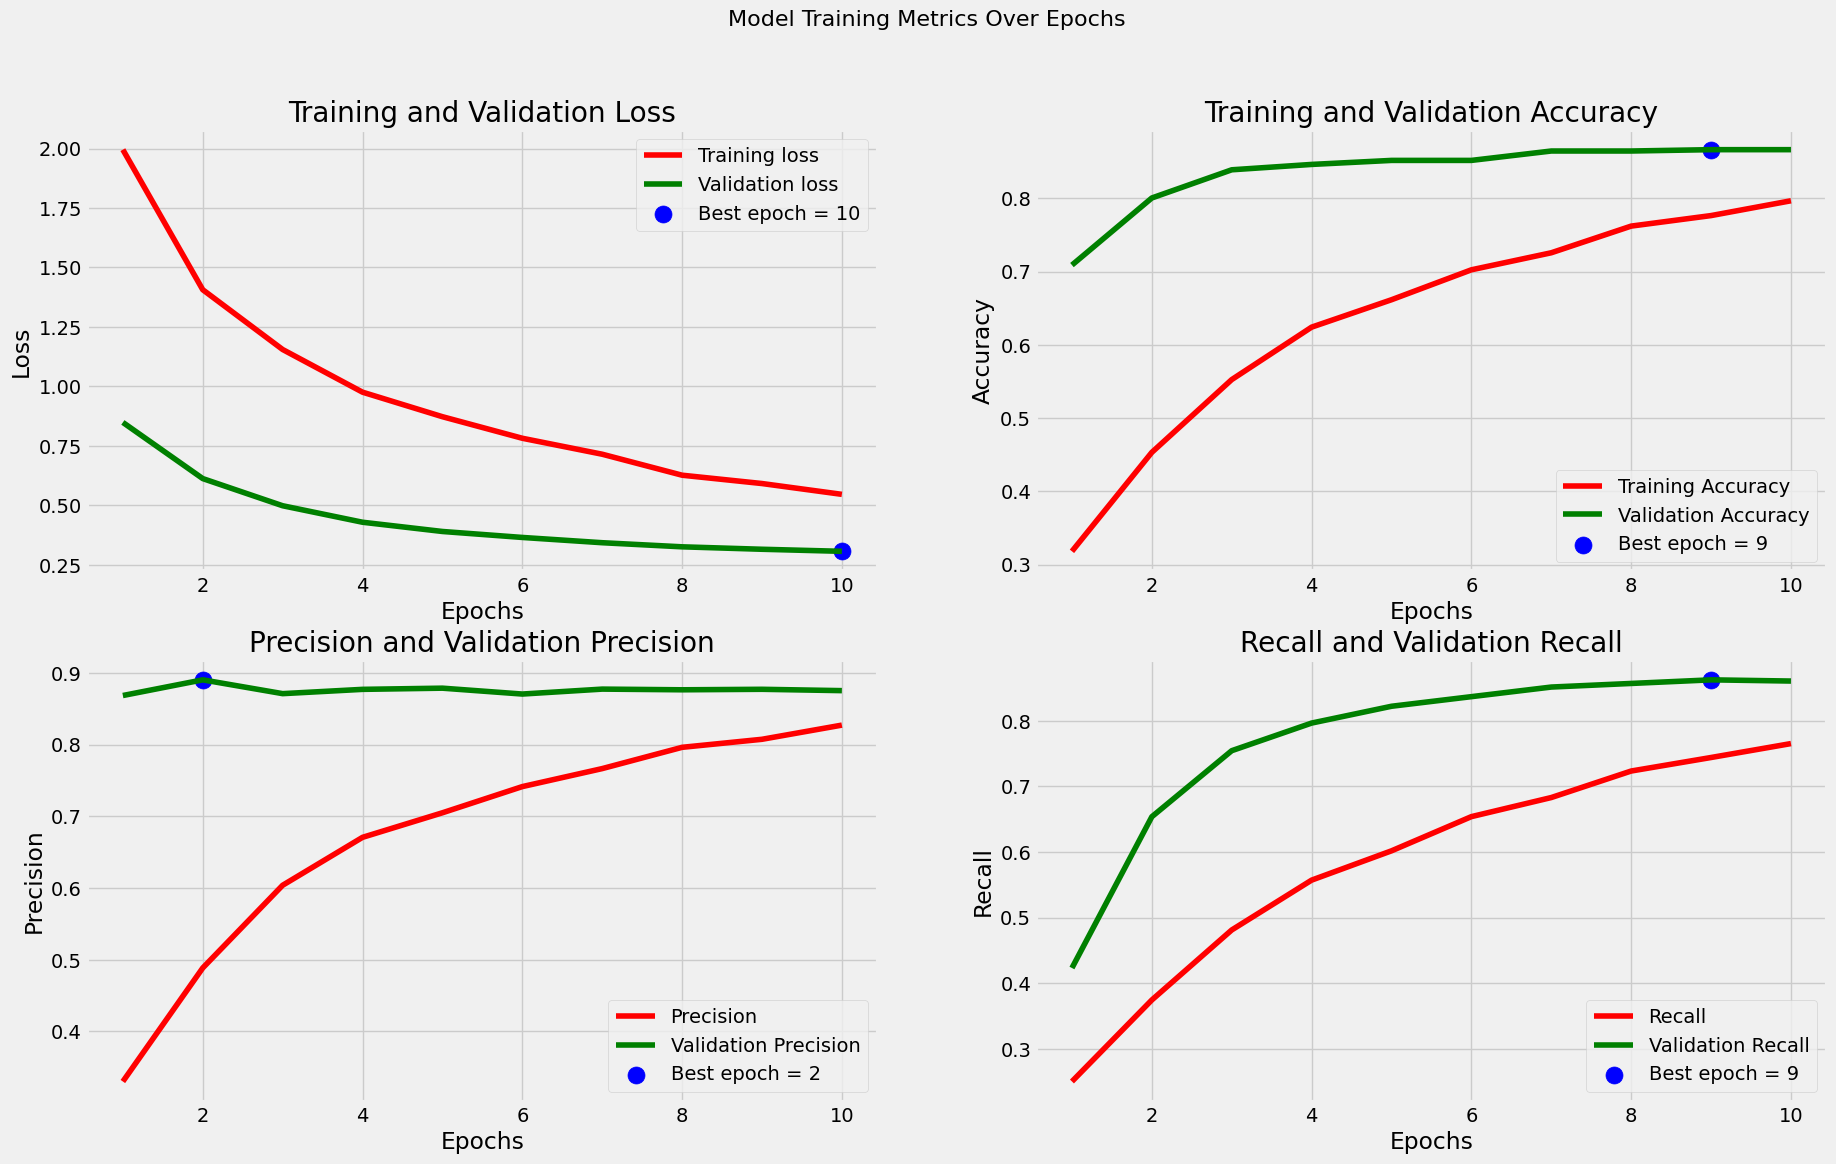

18/18 [==============================] - 1s 70ms/step - loss: 0.2720 - accuracy: 0.8828 - precision: 0.8985 - recall: 0.8755
Train Loss: 0.2961
Train Accuracy: 89.34%
--------------------
Validation Loss: 0.3067
Validation Accuracy: 86.63%
--------------------
Test Loss: 0.2720
Test Accuracy: 88.28%


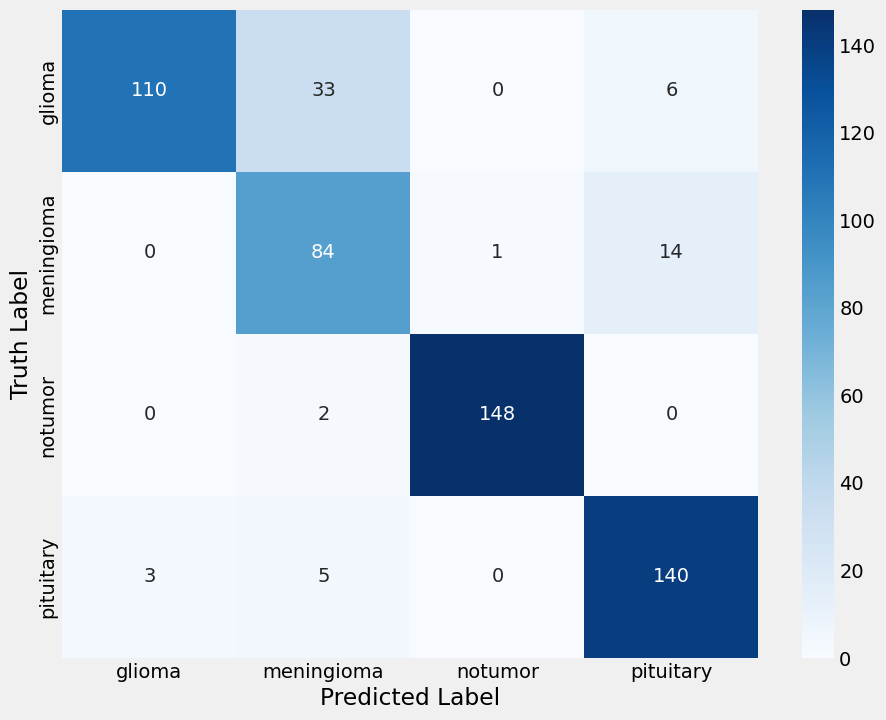

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       149
           1       0.68      0.85      0.75        99
           2       0.99      0.99      0.99       150
           3       0.88      0.95      0.91       148

    accuracy                           0.88       546
   macro avg       0.88      0.88      0.87       546
weighted avg       0.90      0.88      0.88       546



In [3]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Visualize model performance
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Testing and Evaluation
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(tr_gen.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

clr = classification_report(ts_gen.classes, y_pred)
print(clr)